### Определим параметры кеша

Воспользуемся командой lscpu

<pre>Architecture:          x86_64
CPU op-mode(s):        32-bit, 64-bit
Byte Order:            Little Endian
CPU(s):                4
On-line CPU(s) list:   0-3
Thread(s) per core:    2
Core(s) per socket:    2
Socket(s):             1
NUMA node(s):          1
Vendor ID:             GenuineIntel
CPU family:            6
Model:                 58
Stepping:              9
CPU MHz:               1200.000
BogoMIPS:              5980.07
Virtualization:        VT-x
L1d cache:             32K
L1i cache:             32K
L2 cache:              256K
L3 cache:              4096K
NUMA node0 CPU(s):     0-3</pre>

Уже из этой статистики можно понять, что L1 кеш делится на 2 32Кб кеша - для инструкций и для данных (нам нужен только кеш с данными, кеш инструкций затрагивать не будем). Не хватает лишь информации о, том, какие кеши являются общими для ядер процессора, а какие нет + нет информации о размере кеш-линии и канальности кешей. Попробуем получить недостающую информацию по http://www.cpu-world.com/CPUs/Core_i7/Intel-Core%20i7-3540M%20(PGA)%20Mobile%20processor.html

Узнали, что кеши L1 и L2 свои для каждого процессора, а вот L3 общий. Для уточнения остальных характеристик я написал небольшой скрипт [get_cache_params.sh](get_cach_params.sh)

<pre>L1 cache size: 32K
L1 ways count: 8
L1 line size: 64
L2 cache size: 256K
L2 ways count: 8
L2 line size: 64
L3 cache size: 4096K
L3 ways count: 16
L3 line size: 64</pre>

<pre>Отлично, все параметры собраны, итого:
размер L1,L2,L3 = {32К, 256К, 4096К}
канальность = {8, 8, 16}
линия кеша = 64б</pre>

Теперь напишем код для анализа числа кеш-промахов. Помимо кеш промахов, посчитаем длину серий между последовательными обращениями по одному и тому же адресу в кеш (будем учитывать как те значения, которые уже лежат в кеше, так и те, которые уже были оттуда вытеснены) - такой подход позволит прикинуть, какую желаемую канальность кеша мы бы хотели, чтобы минимизировать количество вытеснений. Для тестирования был написан класс TCacheEmulator, код здесь: [main.cpp](main.cpp), [cache.h](cache.h), [treap.h](treap.h)

Используются 2 подхода для определения эффективности кеша - подход с выталкиванием элемента, к которому не доступались дольше всего и с выбрасыванием случайного элемента

<pre>Перед тем, как описать конфигурацию экспериментов, опишу алгоритм расчёта нужных характеристик:
    1) При очередном доступе мы проверяем кеш линии данного индекса на наличие тега
    2) В случае хита - обновляем время послнего доступа к элементу и переходим к шагу 3.
    3) В случаае мисса - вытесняем элемент из кеша в соответсвии с выбранной политикой, и увеличиваем количество миссов на 1 (я использовал приоритетную кучу, чтобы быстро вытеснять элемент при использовании подхода fifo. Проблема возникала, в случае хита - т.к. в этом случае приходилось перестраивать кучу (ключом в ней выступает время последнего доступа, значением - тег). Строго говоря, проблемой это и не является, т.к канальность - либо 8, либо 16.
    4) Храним 2 структуры: map: тег -> последнее время доступа и произвольное сбалансированнное дерево поиска, хранящее текущие последние времена доступа (я использовал treap by e-maxx). На каждой итерации, мы обновляем map и считаем количество вершин в treap > последнее время доступа по тегу, после чего обновляем структуры. Это позволяет в онлайне считать количество доступов по уникальным адресам между последовательным доступом к заданному элементу.
    Более подробно рассказывать, видимо смысла нет (кажется, и так понятно), и в общем, есть код, который, хочется верить, не так уж плохо написан :) </pre>

Тестируем основные значения: (1023, 1024, 1025, 1040, 1041, 1050, 1100) x {выбор по времени доступа, random} x {L1, L2, L3} - всего 42 запуска. + протестированы были ещё 3 доп варианта = 45 запусков. Используем скрипт [cache_emulator](cache_emulator.sh) // все данные в файле [stats.tsv](stats.tsv)

./cache_emulator > stats.tsv 2>&1

Теперь аккуратно распарсим результат выполнения

In [3]:
from collections import defaultdict

def parse_cache_data(filename):
    result = defaultdict(lambda: defaultdict(
            lambda: defaultdict(list)))
    n = -1
    cs = -1; ls = -1; wc = -1; tp = None
    misses_prc = 0
    dst = None
    with open(filename, 'r') as file:
        for line in file:
            if "Stats for " in line:
                pass
            elif "n = " in line:
                n = int(line.split("=")[1].strip())
            elif "CacheSize" in line:
                fields = line.split()
                cs = fields[1]; ls = fields[3]
                wc = fields[5]; tp = fields[7]
            elif "Cache Misses" in line:
                misses_prc = float(line.split()[3][1:-2])
            elif "Count" in line:
                dst = line.split()[1][1:-1]
            elif "timeSimple" in line:
                result[(cs,ls,wc,tp)][n]["misses_prc"].append(misses_prc)
            else:
                i, count = map(int, list(map(str.strip, line.split("->"))))
                result[(cs,ls,wc,tp)][n][dst].append((i, count))
        return result
                

In [4]:
parsed_data = parse_cache_data("stats.tsv")

In [8]:
def cache_name(key):
    to_name = {('262144', '8', '64', 'FIFO') : 'L2-FIFO',
     ('8192', '8', '64', 'FIFO') : 'TEST-FIFO',
     ('32768', '8', '64', 'FIFO') : 'L1-FIFO',
     ('262144', '8', '64', 'RANDOM') : 'L2-RANDOM',
     ('4194304', '16', '64', 'FIFO') : 'L3-FIFO',
     ('32768', '8', '64', 'RANDOM') : 'L1-RANDOM',
     ('4194304', '16', '64', 'RANDOM') : 'L3-RANDOM'}
    return to_name[key]

In [94]:
fifo_res = [(cache_name(k), v) for k, v in parsed_data.items()
            if len(k[0]) > 4 and k[3] == 'FIFO']

rand_res = [(cache_name(k), v) for k, v in parsed_data.items()
            if len(k[0]) > 4 and k[3] == 'RANDOM']

rest_res = [(cache_name(k), v) for k, v in parsed_data.items()
            if len(k[0]) == 4]

In [147]:
import pylab
import operator

def plotAllMisses(items):
    def plotMiss(item, i):
        label = item[0]
        data = [(k, v['misses_prc']) for k, v in item[1].items()]
        sorted_data = sorted(data, key=operator.itemgetter(0))
        if sorted_data[0][0] == 0:
            sorted_data = sorted_data[3:]
        x = [_[0] for _ in sorted_data]
        y = [_[1][0] for _ in sorted_data]
        pylab.figure(i)
        pylab.plot(x, y)
        #print((x,y))
        #pylab.xticks(x)
        my = int(max(y))
        step = int((float(my) + 8) / 8.0)
        pylab.yticks(range(0, my + 6, step))
        pylab.xlabel('matrix size')
        pylab.ylabel('misses %')
        pylab.title(label)
    items = sorted(items, key=operator.itemgetter(0))
    i = 0
    for item in items:
        plotMiss(item, i)
        i += 1

In [21]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [123]:
from pylab import rcParams
rcParams['figure.figsize'] = 20, 5

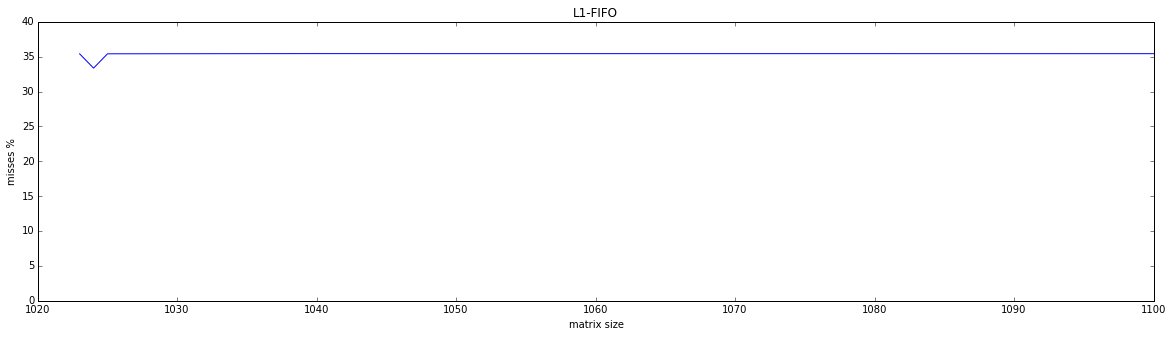

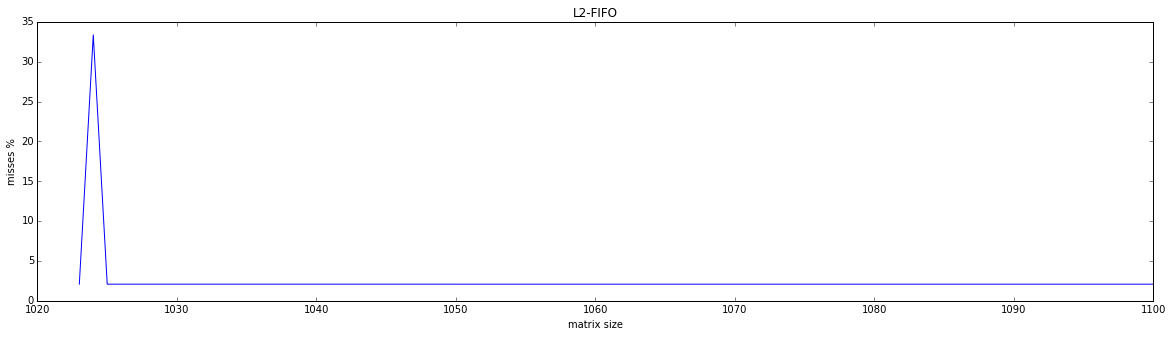

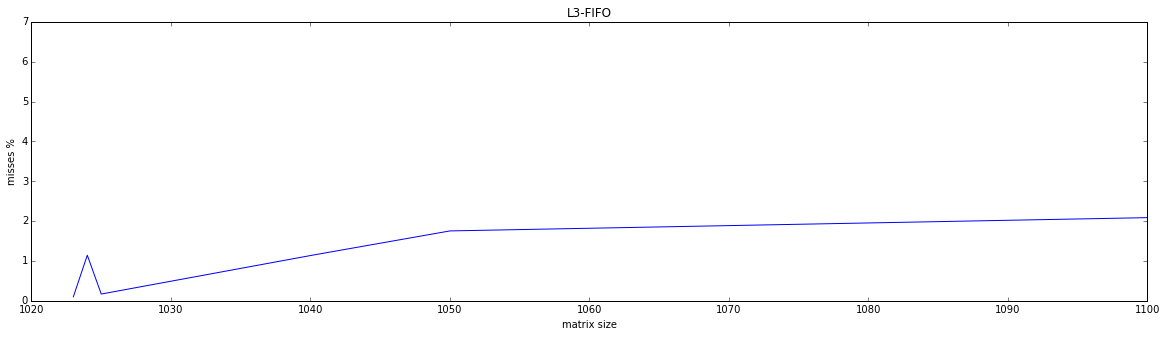

In [148]:
plotAllMisses(fifo_res)


<pre>Рассмотрим полученные графики и сделаем выводы:
1) У L2 и L3 кешей заметен существенный скачок в количестве кеш-миссов при размере матрицы = 1024. При других значениях подобных пиков не наблдюдается.
При этом, пик в случае с L3 менее выражен, что связано с большей канальностью кеша L3 (16 vs 8 у L2). За счёт размера количество кеш миссов у L3 и на других размерах меньше, чем у L1 и L2
2) у L1 подобного поведения не замечено, количество миссов стабильно высокое ~ 35%. Почему так происходит? Скорее всего, дело в том, что L1 слишком маленький сам по себе и все адреса, которые, как мы могли бы ожидать, вытеснялись бы за счёт попадания в тот же индекс элементов из столбца при размере = 1024, уже вытеснены оттуда к этому моменту. Таким образом, кеш миссы L1 не влияют на время перемножения матриц такого размера (в отличие от L2). Вообще, это стоит проверить, взяв даже маленький размер матрицы и подобрав такой размер кеша, чтобы явление всё же наблюдалось. Обозначим эту гипотезу за (*) и вернемся к ней позже. Пока же посмотрим на графики для случайного вытеснения</pre>

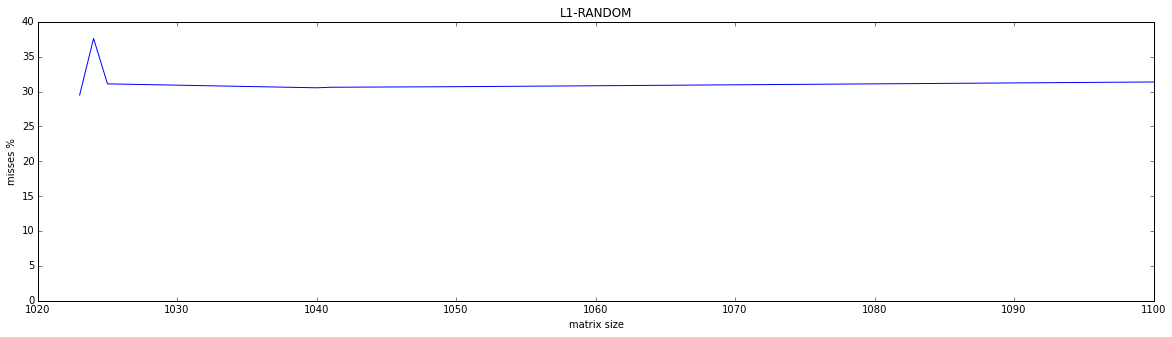

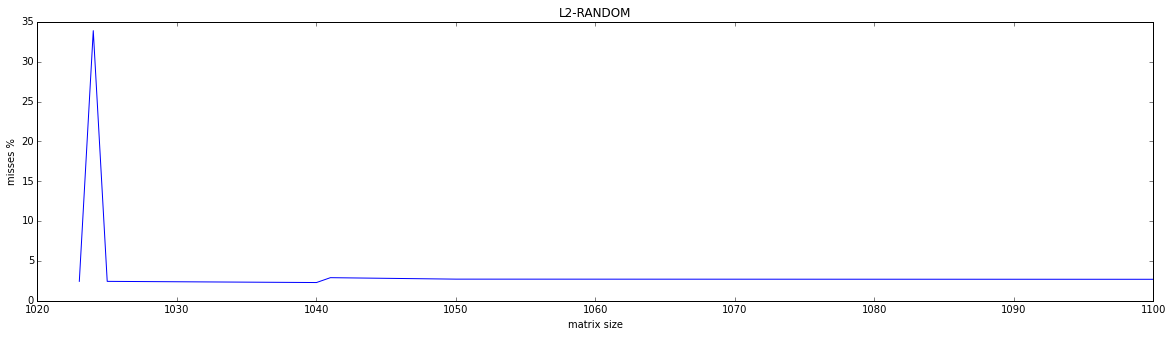

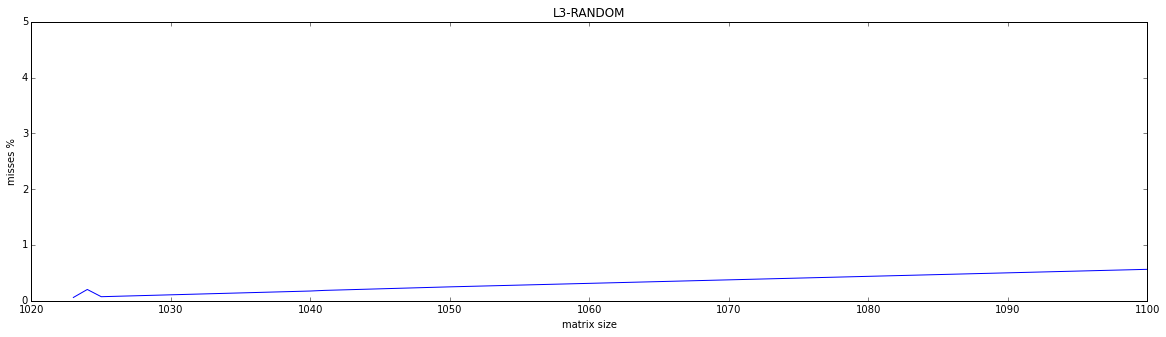

In [149]:
plotAllMisses(rand_res)

<pre>Результаты здесь, в общем и целом, подтверждают результаты для вытеснения по приоритету, но отмечу несколько деталей:
1) В среднем, количество кеш-промахов для L3 меньше, чем в первом варианте ( в меньшей степени это касается L1, который на таких размерах матриц всё равно даёт большой промах)
2) Такая реализация может быть эффективной за счёт своей простоты - т.к. извлечение минимума из 16 (8) значений, в зависимости от канальности, может всё же занимать больше времени, чем случайный выбор</pre>

Теперь вернёмся к гипотезе (\*). Для тестирования я выбрал матрицы размером n=63, n=64, n=65 (64 - степень двойки и её окрестность). Под такой размер кэш L1 был слишком велик (32Кб - кеш миссов не было вообще), поэтому я смоделировал 8 канальный кеш, размером 8Кб, с использованием стратегии вытеснения FIFO. Мы ожидаем увидеть на графике то же, что видели в случае L2 - пик в 64 (и малое количество промахов в 63 и 65), это позволит показать, что предположение о преждевременном вытеснении адресов из кеша верно

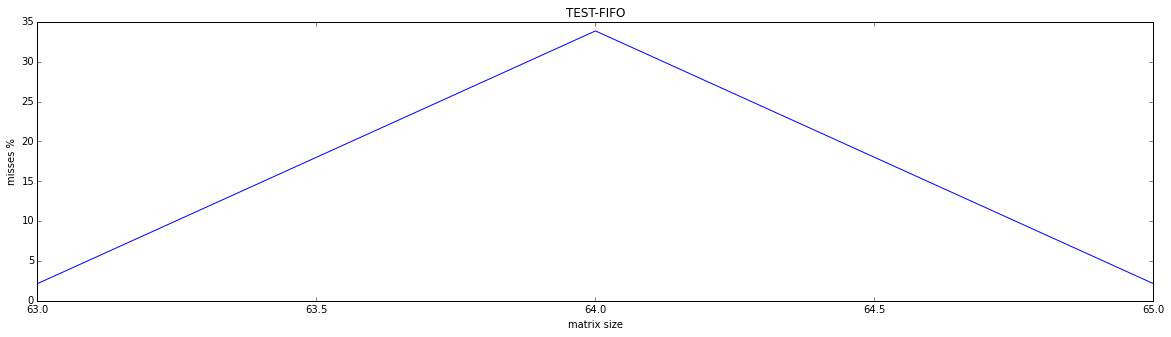

In [150]:
plotAllMisses(rest_res)

Действительно, мы получили тот результат, что и ожидали! Дальнейшее уменьшение размера кеша (до 4Кб) сделало график ~ эквивалентым L1 (по 35% миссов, вне зависимости от размера)

Осталась последняя часть, которой ранее я уже касался - прикидка оптимальной канальности кеша на основе длины серий между последовательными обращениями по одному и тому же адресу. Отмечу, что я аггрегировал статистику, как и по хитам, так и по миссам отдельно, но, если в случае с случайным вытеснением нужно рассматривать их по отдельности, то в случае с FIFO можно и вместе - понятно, что канальность кеша на гистограмме отделит множество длин серий с хитами от их же с миссами (для наглядности, всё же по отдельности). Вообще, представление об оптимальной канальности в 16 уже есть - за счёт сравнения результатов L2 и L3. Вдобавок у них разный размер, что говорит о том, что прикидка носит приблизительный характер (увеличение канальности L2 до 16 уменьшит количество индексов в нём, что может привести к большему количеству миссов(за счёт попадания большего количества адресов в один и тот же индекс)), но тем не менее, такое исследование достаточно интересно. Кроме того, пожалуй не будем приводить графики для всех кешей (остановимся на L2)  и посмотрим на графики для размеров 1023, 1024, 1025 x {FIFO / RAND} x2 (hits / misses) - в сумме это 12 графиков

In [176]:
import pylab
import operator

def plotAllSeries(item, classes):
    def plotSingleSeries(item, i, cl, size):
        label = item[0] + "-" + cl + "-" + str(size)
        data = [(k, v) for k, v in item[1][size][cl]]
        sorted_data = sorted(data, key=operator.itemgetter(0))
        x = [_[0] for _ in sorted_data]
        y = [_[1] for _ in sorted_data]
        pylab.figure(i)
        pylab.plot(x, y)
        #print((x,y))
        #pylab.xticks(range(1, x[-1] + 10, 8))
        #my = int(max(y))
        #step = int((float(my) + 8) / 8.0)
        #pylab.yticks(range(0, my + 6, step))
        pylab.xlabel('series length')
        pylab.ylabel('count')
        pylab.title(label)
    i = 0
    for size in [1023, 1024, 1025]:
        for cl in classes:
            plotSingleSeries(item, i, cl, size)
            i += 1

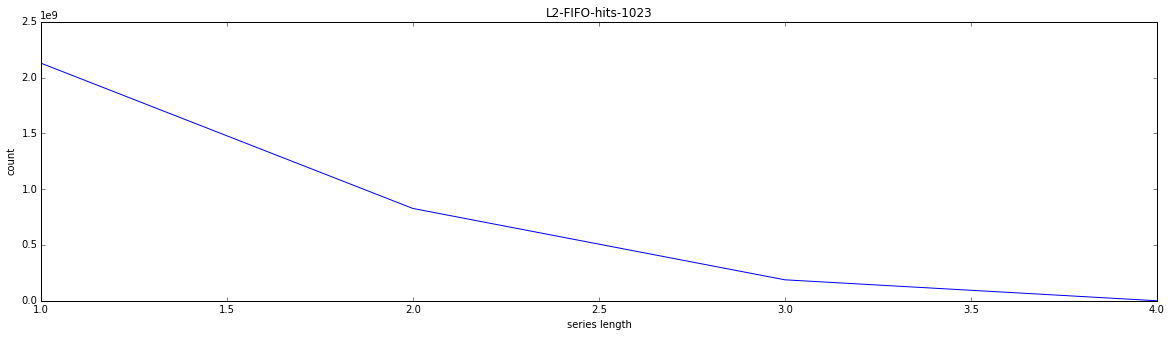

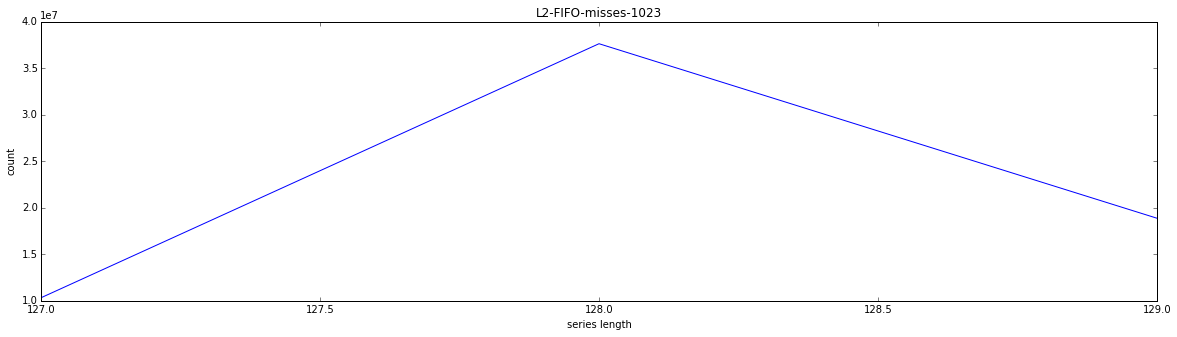

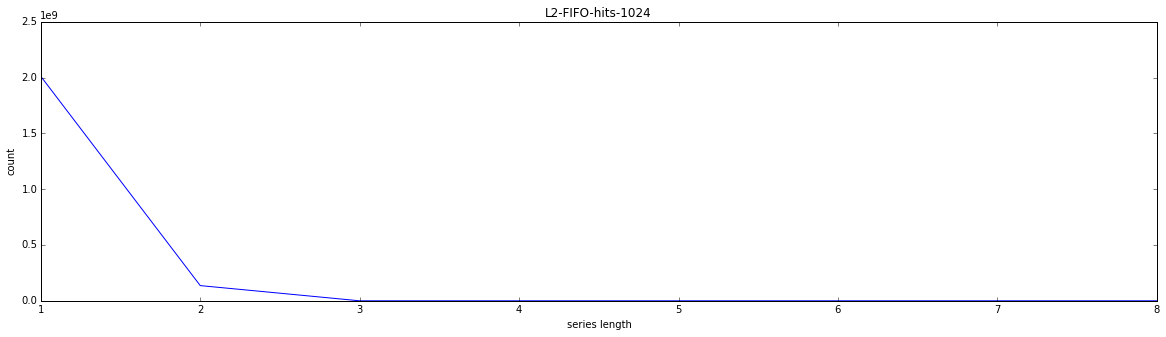

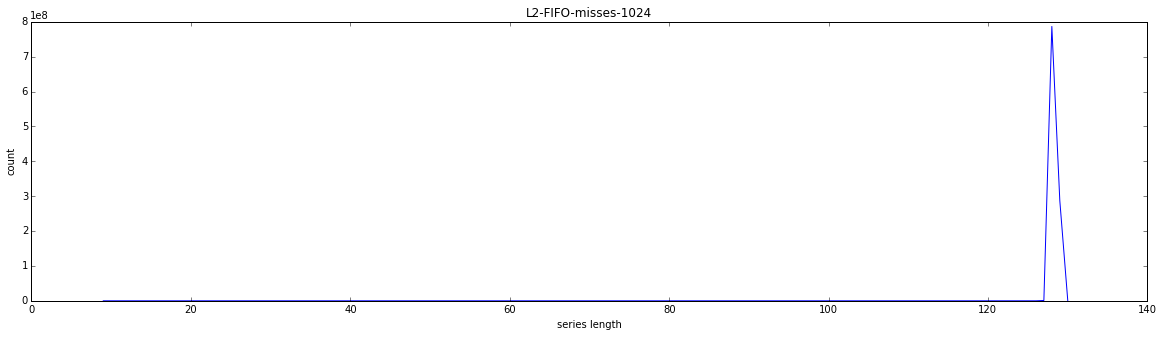

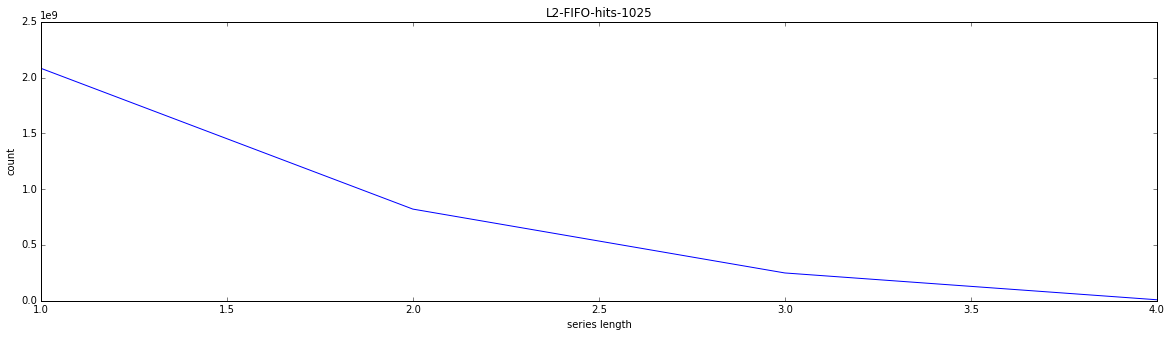

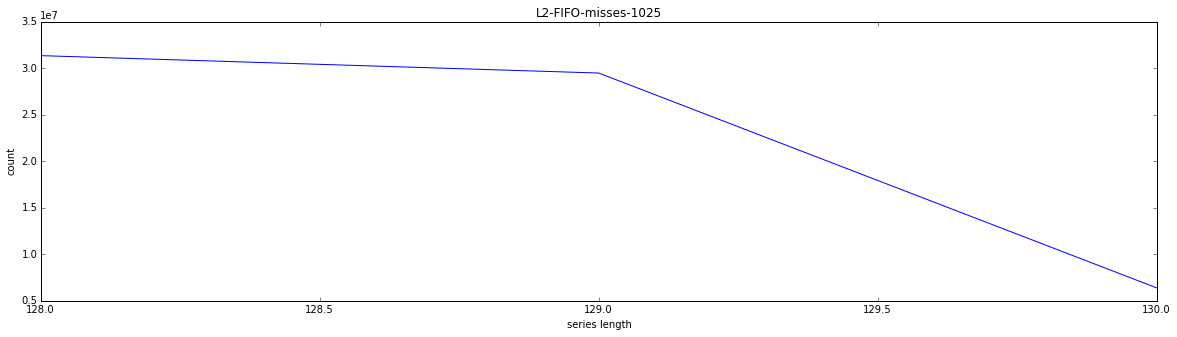

In [177]:
plotAllSeries(fifo_res[0], ['hits', 'misses'])

Уже эти графики кажутся весьма занятными - видно, что для L2 длина серий между хитами не превышает 4 (т.е. мы не в полной мере используем 8канальность нашего кеша), причём больше всего серий длины 1 (что логично). Но вот предположение об оптимальности 16-канального кеша не подтвердилось - видно, что большинство миссов происходят с длиной серии 128 (причём для 1024 это число на порядок больше). А посмотрим ка на L1: 

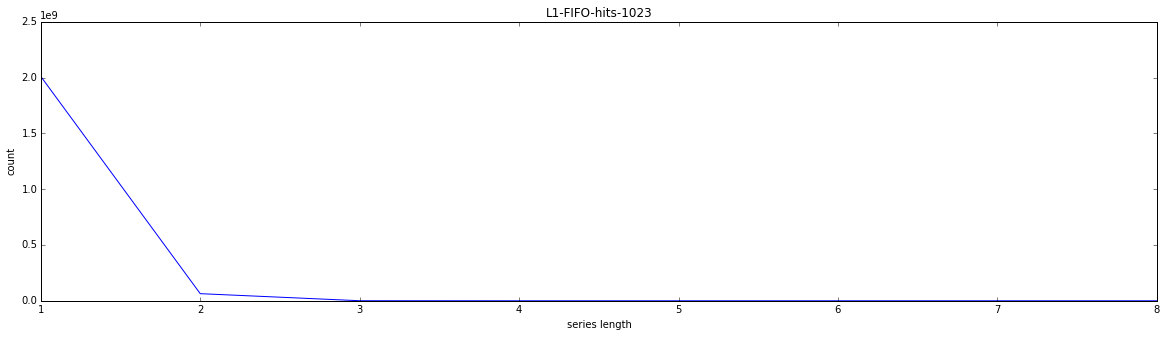

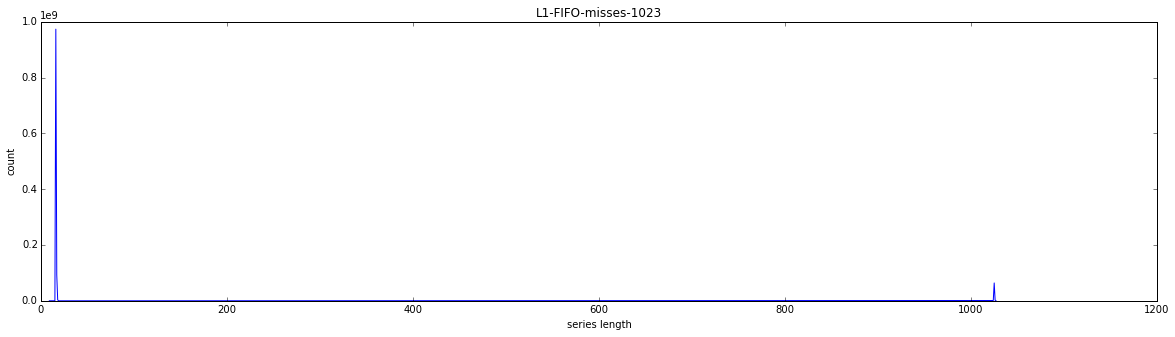

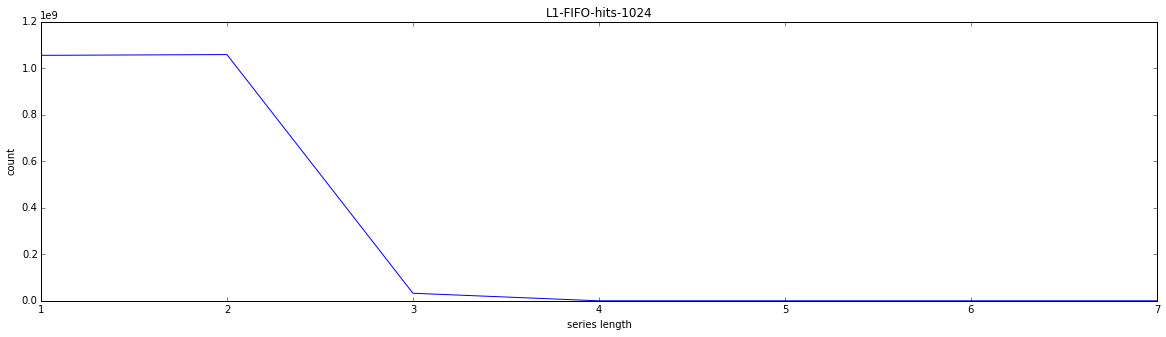

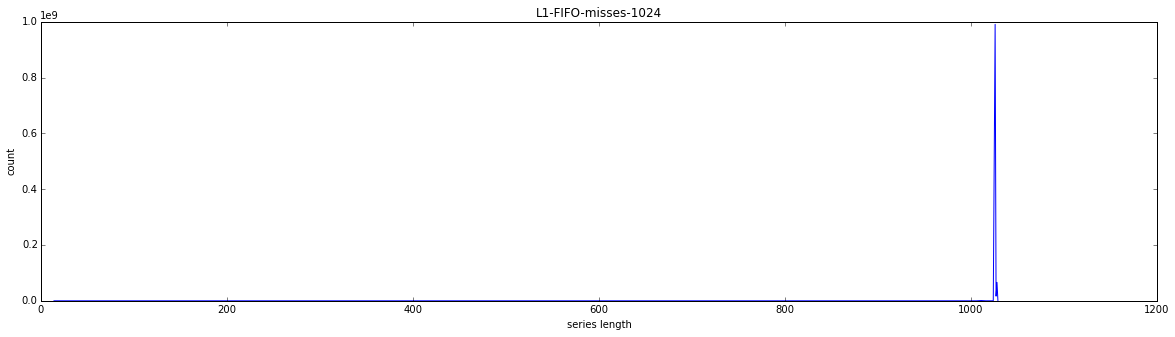

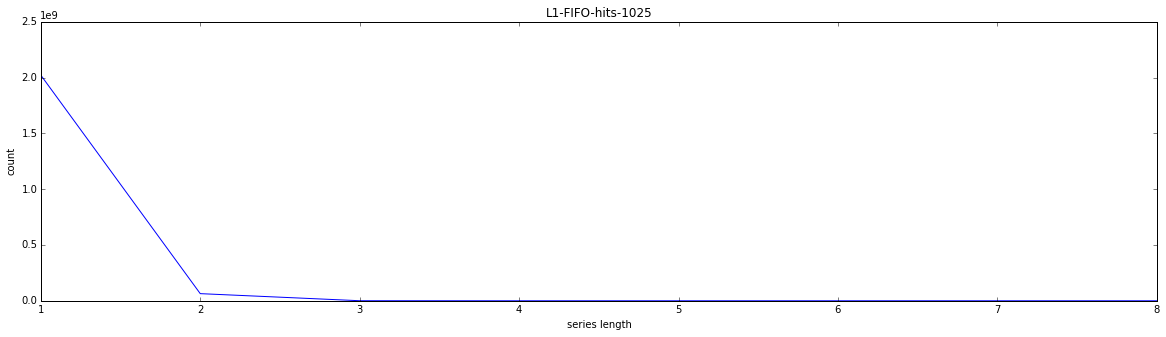

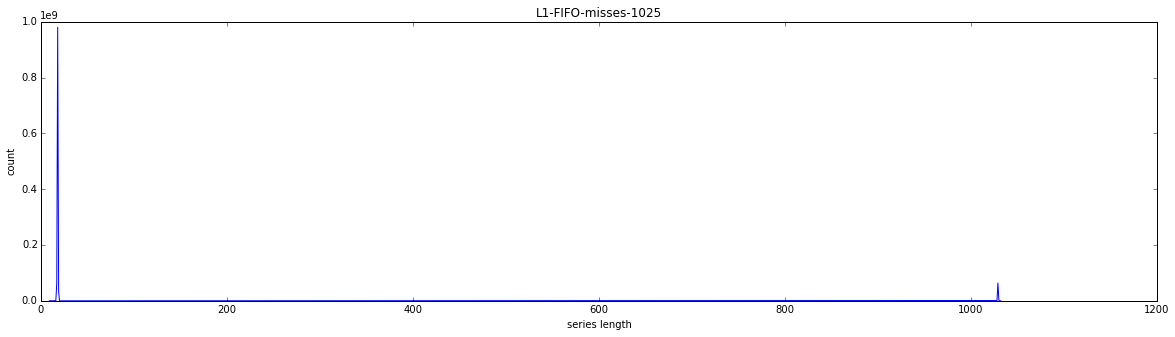

In [178]:
plotAllSeries(fifo_res[1], ['hits', 'misses'])

В данном случае расстояние между хитами в среднем, не превосходит двойки, а насчёт миссов, есть огромный пик в 16 (а для случая 1024 - в 1024) Осталось посмотреть на результаты рандома

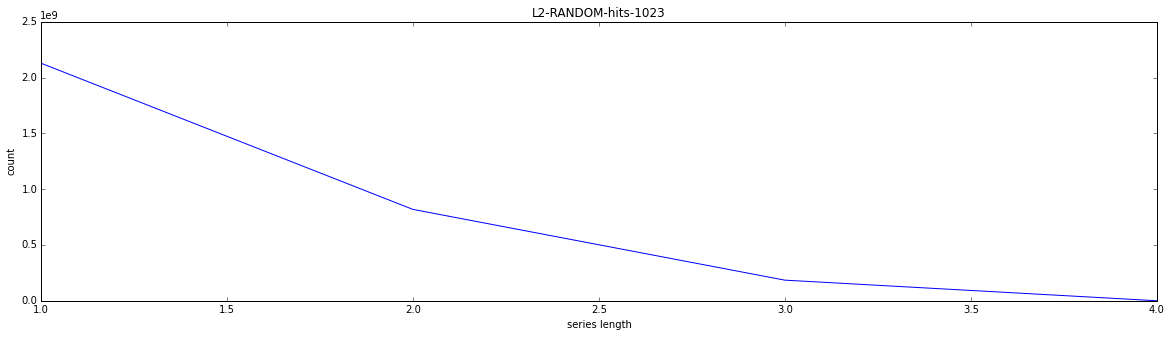

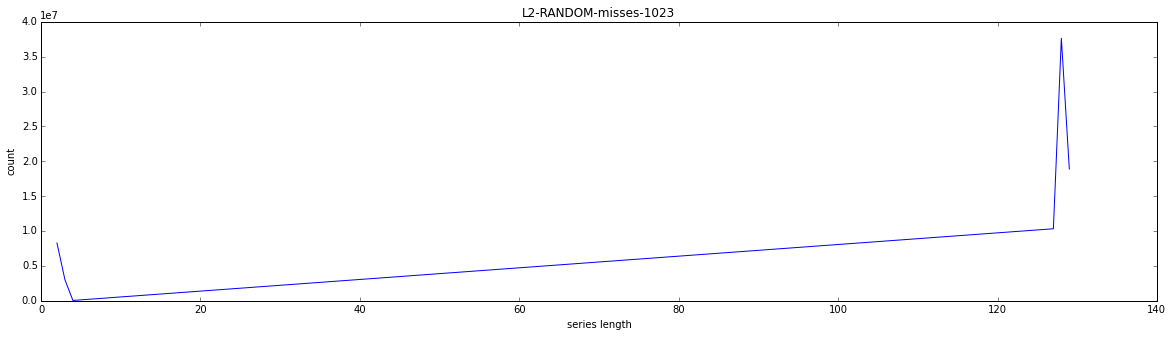

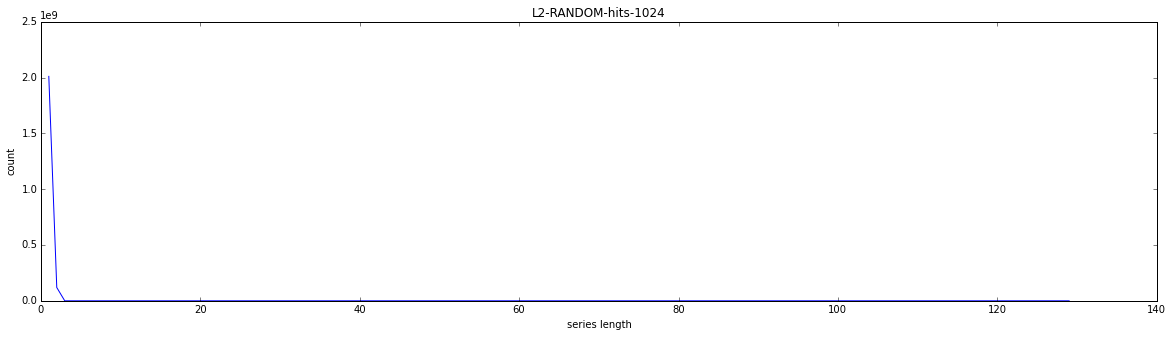

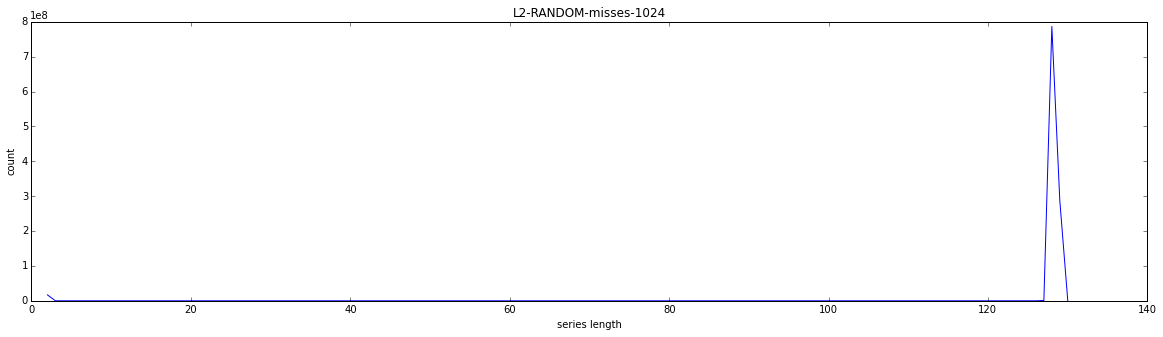

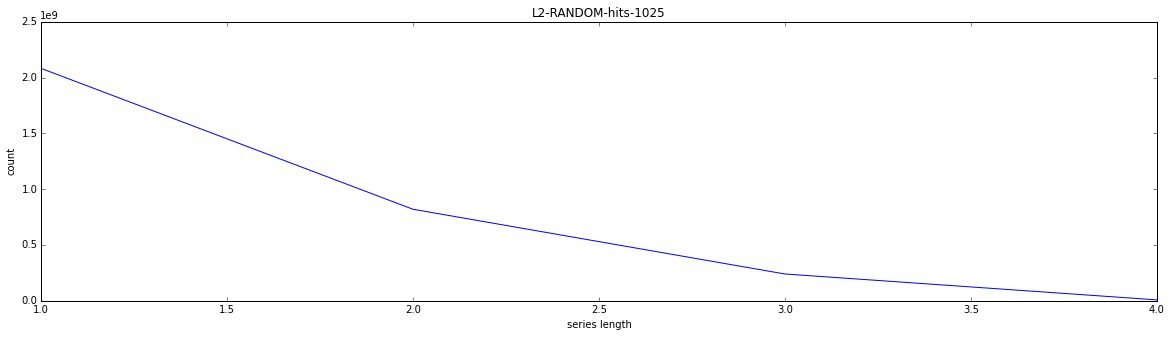

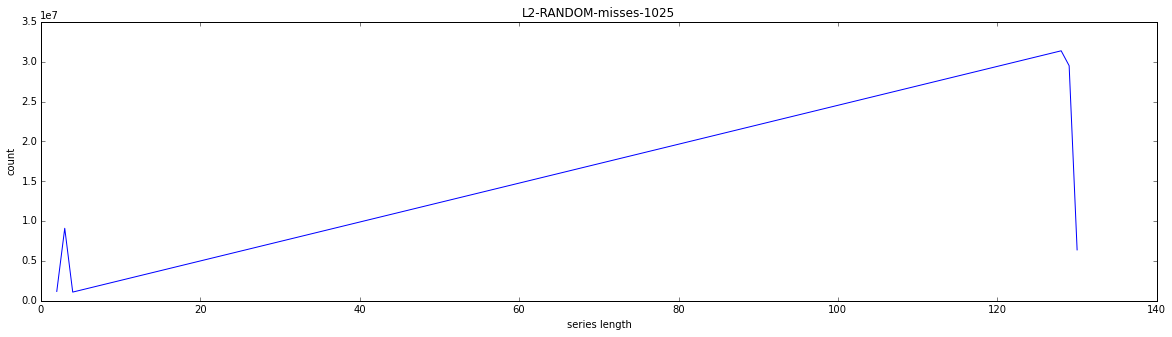

In [180]:
plotAllSeries(rand_res[0], ['hits', 'misses'])

Для random стратегии всё сильно похоже на FIFO, за вычетом редких хитов на очень поздних позициях и относительно частыми миссами на не очень больших

В общем, можно сделать вывод, что размер кеша подобран адекватно (разве что для L1 возможно, 16 канальный кеш для нашей задачи был бы лучше, учитывая пики для миссов в районе 16 для размеров 1023 и 1025)

Осталось последнее - замерить количество кеш-миссов с помощью valgrind  и сравнить с результатами, полученными в отчёте - воспользуемся скриптом [valgrind_calc.sh](valgrind_calc.sh) // исходник можно посмотреть [тут](main_default.cpp)

In [210]:
def parse_valgrind(l1l3, l2):
    def nfl(l):
        return float(l.split(':')[1].split('(')[0].strip()[:-1])
    res = {'l1' : [], 'l2' : [], 'l3' : []}
    with open(l1l3, 'r') as f1, open(l2, 'r') as f2:
        n = 0
        for line in f1:
            if "n = " in line:
                n = int(line.split('=')[1].strip())
            elif "D1  miss rate" in line:
                res['l1'].append((n, nfl(line)))
            elif "LLd miss rate" in line:
                res['l3'].append((n, nfl(line)))
        for line in f2:
            if "n = " in line:
                n = int(line.split('=')[1].strip())
            elif "LLd miss rate" in line:
                res['l2'].append((n, nfl(line)))
    return res

In [204]:
def plot_valgrind(label, items):
    items = sorted(items, key=operator.itemgetter(0))
    x = [_[0] for _ in items]
    y = [_[1] for _ in items]
    my = int(max(y))
    step = int((float(my) + 8) / 8.0)
    pylab.plot(x,y)
    pylab.yticks(range(0, my + 6, step))
    pylab.xlabel('matrix size')
    pylab.ylabel('misses %')
    pylab.title(label)

In [216]:
vd = parse_valgrind('l1l3.data', 'l2.data')

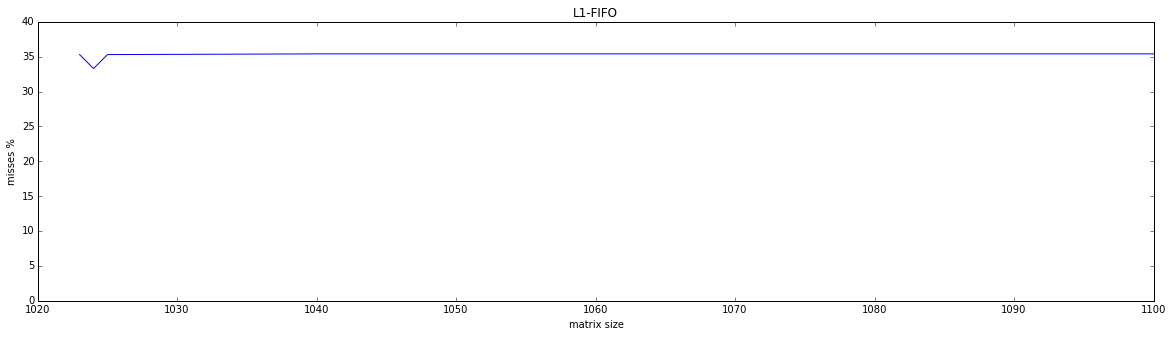

In [217]:
plot_valgrind('L1-FIFO', vd['l1'])

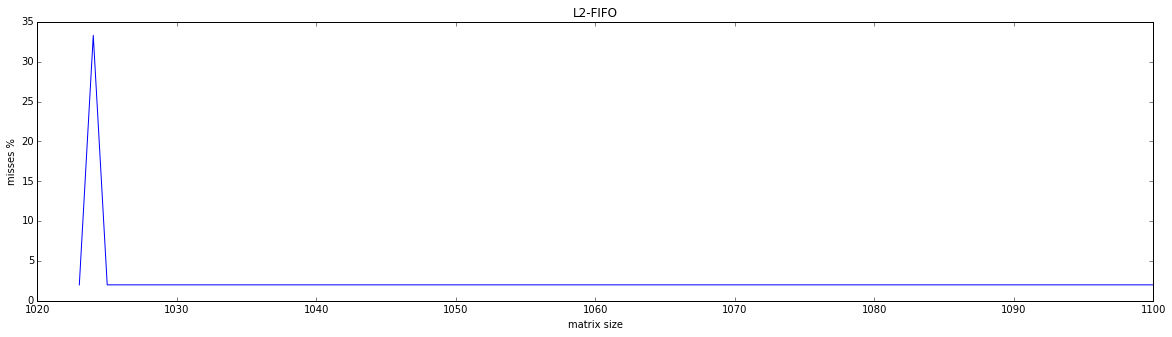

In [205]:
plot_valgrind('L2-FIFO', vd['l2'])

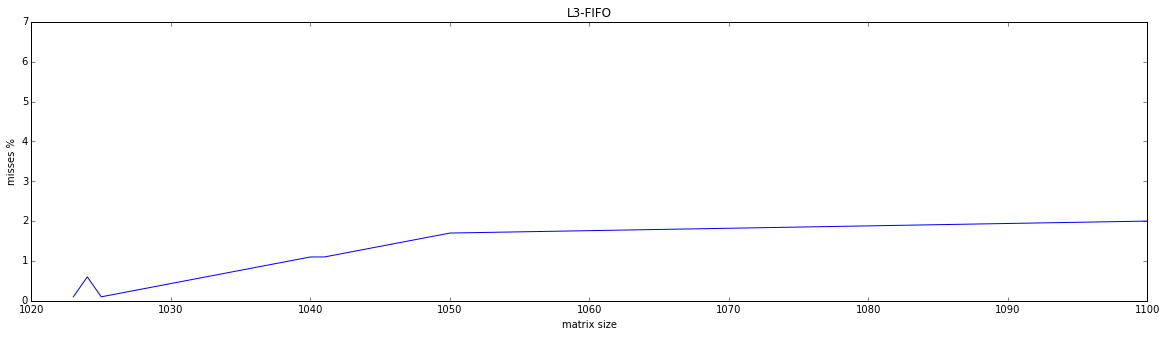

In [206]:
plot_valgrind('L3-FIFO', vd['l3'])

Нетрудно убедиться, что графики valgrind полностью идентичны графикам, полученным в отчёте ранее (т.е. кэш использует стратегию FIFO)